In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../Task 1/')
from efficient_apriori import apriori
from improved_apriori import Improved_Apriori
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
data = pd.read_csv('../Task 2/dataset/final_animedataset.csv')
data = data[['username', 'title']]
data = data.groupby('username')['title'].apply(list)
data = data.to_dict()

In [3]:
# Step 2: Frequent Itemset Generation
# Use the apriori algorithm to generate frequent itemsets
apriori = Improved_Apriori(data, min_support=0.4, min_confidence=1)
frequent_itemsets = apriori.apriori()
frequent_itemsets

100%|██████████| 78/78 [00:01<00:00, 56.90it/s]
0it [00:00, ?it/s]


{1: {('Angel Beats!',): 65303,
  ('Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.',): 49456,
  ('Another',): 51658,
  ('Ao no Exorcist',): 53028,
  ('Bakemonogatari',): 57273,
  ('Bleach',): 63861,
  ('Byousoku 5 Centimeter',): 47041,
  ('Clannad',): 63023,
  ('Clannad: After Story',): 50104,
  ('Code Geass: Hangyaku no Lelouch',): 71414,
  ('Code Geass: Hangyaku no Lelouch R2',): 58654,
  ('Cowboy Bebop',): 51706,
  ('Darker than Black: Kuro no Keiyakusha',): 51982,
  ('Death Note',): 85642,
  ('Durarara!!',): 59267,
  ('Elfen Lied',): 68075,
  ('Fairy Tail',): 53143,
  ('Fate/stay night',): 48914,
  ('Fullmetal Alchemist',): 61241,
  ('Fullmetal Alchemist: Brotherhood',): 67132,
  ('Highschool of the Dead',): 55774,
  ('Higurashi no Naku Koro ni',): 49684,
  ('K-On!',): 50388,
  ('Mahou Shoujo Madoka★Magica',): 48549,
  ('Mirai Nikki (TV)',): 57010,
  ('Naruto',): 66343,
  ('Naruto: Shippuuden',): 53626,
  ('Neon Genesis Evangelion',): 52984,
  ('No Game No Life',): 48171,


In [4]:
# Create a binary matrix
# Flatten the dictionary into a list of itemsets
from tqdm import tqdm
itemsets = [itemset for level in frequent_itemsets.values() for itemset in level.keys()]

# Transactions 
transactions = list(data.values())

binary_matrix = pd.DataFrame(0, index=range(len(transactions)), columns=itemsets)

# Fill in the binary matrix
for i, transaction in enumerate(tqdm(transactions)):
    for itemset in itemsets:
        if set(itemset).issubset(transaction):
            binary_matrix.at[i, itemset] = 1  # Use 'at' instead of 'loc' for scalar indexing

binary_matrix


 16%|█▌        | 18711/116124 [00:31<03:01, 537.10it/s]

100%|██████████| 116124/116124 [03:08<00:00, 616.43it/s]


,"(Angel Beats!,)","(Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.,)","(Another,)","(Ao no Exorcist,)","(Bakemonogatari,)","(Bleach,)","(Byousoku 5 Centimeter,)","(Clannad,)","(Clannad: After Story,)","(Code Geass: Hangyaku no Lelouch,)",...,"(Naruto, Naruto: Shippuuden)","(Shingeki no Kyojin, Steins;Gate)","(Shingeki no Kyojin, Sword Art Online)","(Shingeki no Kyojin, Toradora!)","(Steins;Gate, Sword Art Online)","(Sword Art Online, Toradora!)","(Code Geass: Hangyaku no Lelouch, Code Geass: Hangyaku no Lelouch R2, Death Note)","(Code Geass: Hangyaku no Lelouch, Death Note, Elfen Lied)","(Code Geass: Hangyaku no Lelouch, Death Note, Fullmetal Alchemist: Brotherhood)","(Death Note, Shingeki no Kyojin, Sword Art Online)"
0,0,0,0,0,0,0,1,1,0,1,...,1,0,0,0,0,0,1,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,1,1,0,0,1,0,0,...,1,1,1,1,1,1,0,0,0,1
4,0,0,0,0,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116119,0,0,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
116120,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,1,0,0
116121,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,0,1,1
116122,1,1,1,0,0,0,0,1,1,1,...,0,1,1,0,1,0,0,0,0,0


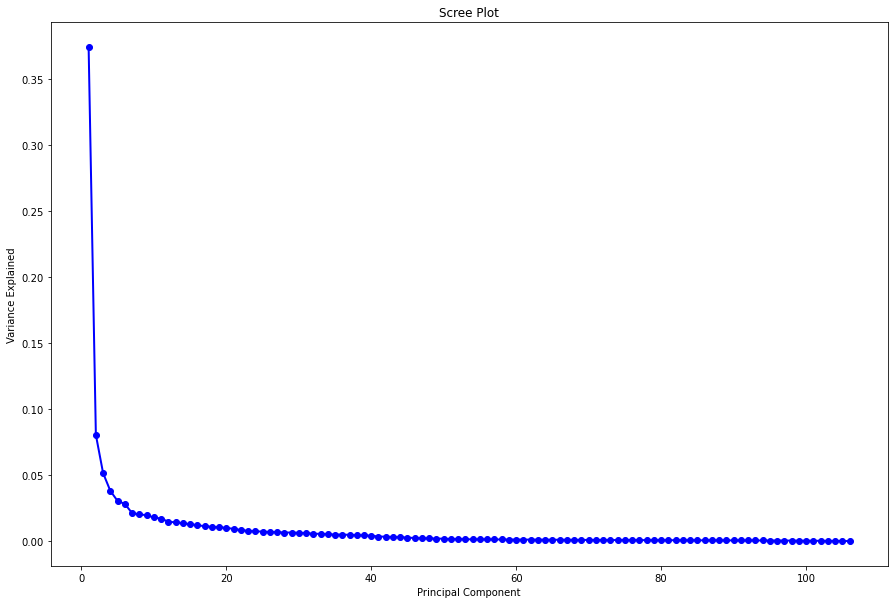

In [5]:
pca = PCA(random_state=24).fit(binary_matrix)
PC_values = np.arange(pca.n_components_) + 1
plt.figure(figsize=(15,10))
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [6]:
pca = PCA(n_components=4, random_state=42)
transformed_data = pca.fit_transform(binary_matrix)

In [7]:
def kmeans_elbow_method(data, max_k=10, figsize=(15, 8)):
    ssd = []
    silhouette_scores = []
    plt.figure(figsize=figsize)
    # Loop through different values of k
    for k in range(2, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        
        # Fit the k-means clustering model to the data
        kmeans.fit(data)
        
        # Calculate the sum of squared distances
        ssd.append(kmeans.inertia_)
        
        # Calculate the average silhouette score
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))
    
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Number of clusters (k)')
    ax1.set_ylabel('Sum of squared distances', color='b')
    ax1.plot(range(2, max_k+1), ssd, 'bo-')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Silhouette score', color='r')
    ax2.plot(range(2, max_k+1), silhouette_scores, 'ro-')
    
    fig.tight_layout()
    plt.show()

/home/FYP/teog0015/.conda/envs/fyp_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/FYP/teog0015/.conda/envs/fyp_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/FYP/teog0015/.conda/envs/fyp_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/FYP/teog0015/.conda/envs/fyp_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly t

<Figure size 1080x576 with 0 Axes>

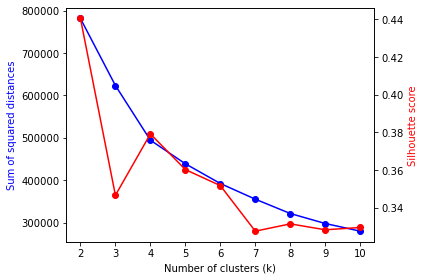

In [8]:
kmeans_elbow_method(transformed_data)

/home/FYP/teog0015/.conda/envs/fyp_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


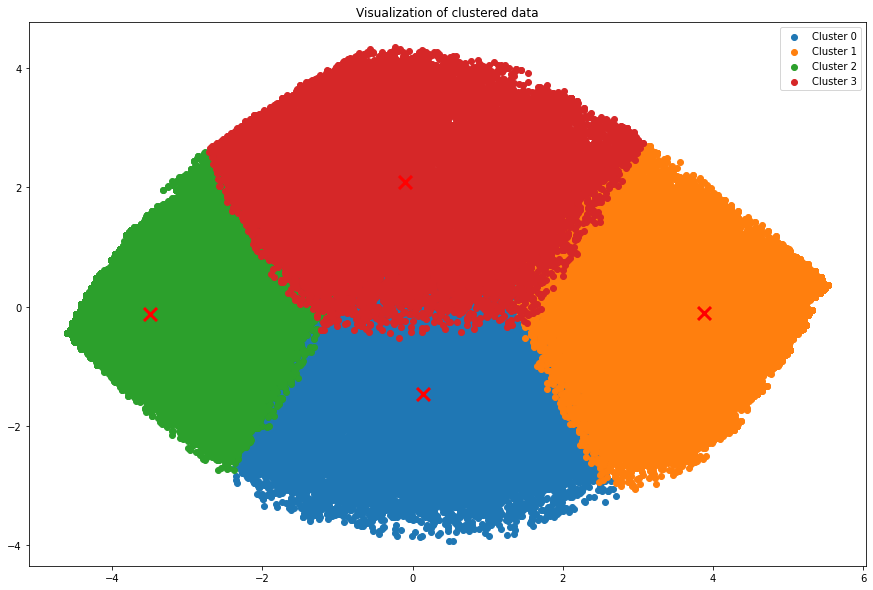

In [9]:
# Number of cluster for K-means to be 4 
k = 4
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(transformed_data)
cluster_labels = kmeans.labels_
kmeans_centroids = kmeans.cluster_centers_
#print(kmeans_centroids)
kmeans_silhouette = silhouette_score(transformed_data, cluster_labels)
plt.figure(figsize=(15,10))
for i in range(k):
    plt.scatter(transformed_data[cluster_labels == i, 0], transformed_data[cluster_labels == i, 1], label='Cluster '+str(i))
plt.legend()

# Plot the centroids

plt.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], marker='x', s=169, linewidths=3, color='r', zorder=10)
plt.title('Visualization of clustered data')
plt.show()

In [10]:
binary_matrix['kmeans_cluster'] = cluster_labels

In [11]:
cluster1 = binary_matrix[binary_matrix['kmeans_cluster'] == 0]
cluster2 = binary_matrix[binary_matrix['kmeans_cluster'] == 1]
cluster3 = binary_matrix[binary_matrix['kmeans_cluster'] == 2]
cluster4 = binary_matrix[binary_matrix['kmeans_cluster'] == 3]
itemsets_in_cluster1 = [col for col in cluster1.columns if cluster1[col].sum() > 0]
itemsets_in_cluster2 = [col for col in cluster1.columns if cluster2[col].sum() > 0]
itemsets_in_cluster3 = [col for col in cluster1.columns if cluster3[col].sum() > 0]
itemsets_in_cluster4 = [col for col in cluster1.columns if cluster4[col].sum() > 0]


In [12]:
for i in range(4):
    print(f'Size of cluster {i+1}: {binary_matrix[binary_matrix["kmeans_cluster"] == i].shape[0]}')

Size of cluster 1: 22621
Size of cluster 2: 34619
Size of cluster 3: 38799
Size of cluster 4: 20085


In [13]:
# Interpreting the itemset frequencies in each cluster
cluster_itemset_frequencies = binary_matrix.groupby('kmeans_cluster').sum()
cluster_itemset_frequencies

,"(Angel Beats!,)","(Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.,)","(Another,)","(Ao no Exorcist,)","(Bakemonogatari,)","(Bleach,)","(Byousoku 5 Centimeter,)","(Clannad,)","(Clannad: After Story,)","(Code Geass: Hangyaku no Lelouch,)",...,"(Naruto, Naruto: Shippuuden)","(Shingeki no Kyojin, Steins;Gate)","(Shingeki no Kyojin, Sword Art Online)","(Shingeki no Kyojin, Toradora!)","(Steins;Gate, Sword Art Online)","(Sword Art Online, Toradora!)","(Code Geass: Hangyaku no Lelouch, Code Geass: Hangyaku no Lelouch R2, Death Note)","(Code Geass: Hangyaku no Lelouch, Death Note, Elfen Lied)","(Code Geass: Hangyaku no Lelouch, Death Note, Fullmetal Alchemist: Brotherhood)","(Death Note, Shingeki no Kyojin, Sword Art Online)"
kmeans_cluster,,,,,,,,,,,,,,,,,,,,,
0,18229,13800,14748,13401,13639,9270,10161,14190,11256,9973,...,8008,14268,17424,14008,14552,14737,3597,2906,2866,12583
1,32368,26881,27939,27787,28820,26157,22657,29237,25280,34457,...,22878,31009,31591,29097,31010,29161,30500,29177,32060,31391
2,7519,4618,5047,5459,5992,12415,5816,8748,5807,7893,...,7290,1861,3496,1935,1716,2640,1743,1107,472,1229
3,7187,4157,3924,6381,8822,16019,8407,10848,7761,19091,...,12246,2638,2570,2243,1808,2045,15260,13424,12251,2474


In [14]:
binary_matrix

,"(Angel Beats!,)","(Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.,)","(Another,)","(Ao no Exorcist,)","(Bakemonogatari,)","(Bleach,)","(Byousoku 5 Centimeter,)","(Clannad,)","(Clannad: After Story,)","(Code Geass: Hangyaku no Lelouch,)",...,"(Shingeki no Kyojin, Steins;Gate)","(Shingeki no Kyojin, Sword Art Online)","(Shingeki no Kyojin, Toradora!)","(Steins;Gate, Sword Art Online)","(Sword Art Online, Toradora!)","(Code Geass: Hangyaku no Lelouch, Code Geass: Hangyaku no Lelouch R2, Death Note)","(Code Geass: Hangyaku no Lelouch, Death Note, Elfen Lied)","(Code Geass: Hangyaku no Lelouch, Death Note, Fullmetal Alchemist: Brotherhood)","(Death Note, Shingeki no Kyojin, Sword Art Online)",kmeans_cluster
0,0,0,0,0,0,0,1,1,0,1,...,0,0,0,0,0,1,1,0,0,3
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,1,0,1,1,1,0,0,1,0,0,...,1,1,1,1,1,0,0,0,1,0
4,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116119,0,0,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,2
116120,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,1,0,0,3
116121,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,0,1,1,1
116122,1,1,1,0,0,0,0,1,1,1,...,1,1,0,1,0,0,0,0,0,0


In [15]:
import ast
binary_matrix['anime_level'] = binary_matrix.apply(lambda row: max([len(col) for col, val in row.items() if val == 1 and col != 'kmeans_cluster' and col!='anime_level'], default=0), axis=1)
binary_matrix


,"(Angel Beats!,)","(Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.,)","(Another,)","(Ao no Exorcist,)","(Bakemonogatari,)","(Bleach,)","(Byousoku 5 Centimeter,)","(Clannad,)","(Clannad: After Story,)","(Code Geass: Hangyaku no Lelouch,)",...,"(Shingeki no Kyojin, Sword Art Online)","(Shingeki no Kyojin, Toradora!)","(Steins;Gate, Sword Art Online)","(Sword Art Online, Toradora!)","(Code Geass: Hangyaku no Lelouch, Code Geass: Hangyaku no Lelouch R2, Death Note)","(Code Geass: Hangyaku no Lelouch, Death Note, Elfen Lied)","(Code Geass: Hangyaku no Lelouch, Death Note, Fullmetal Alchemist: Brotherhood)","(Death Note, Shingeki no Kyojin, Sword Art Online)",kmeans_cluster,anime_level
0,0,0,0,0,0,0,1,1,0,1,...,0,0,0,0,1,1,0,0,3,3
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1
3,1,0,1,1,1,0,0,1,0,0,...,1,1,1,1,0,0,0,1,0,3
4,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116119,0,0,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,2,2
116120,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,1,0,0,3,3
116121,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,0,1,1,1,3
116122,1,1,1,0,0,0,0,1,1,1,...,1,0,1,0,0,0,0,0,0,2


In [16]:
cluster_anime_level_counts = binary_matrix.groupby(['kmeans_cluster', 'anime_level']).size()
cluster_anime_level_counts

kmeans_cluster  anime_level
0               2               8666
                3              13955
1               2                201
                3              34418
2               0               2705
                1               7606
                2              24790
                3               3698
3               2               1900
                3              18185
dtype: int64

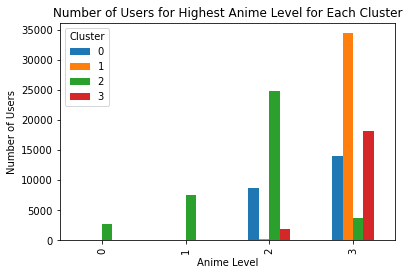

In [17]:
df_counts = cluster_anime_level_counts.reset_index(name='counts')

df_pivot = df_counts.pivot(index='anime_level', columns='kmeans_cluster', values='counts')

# Replace NaN values with 0
df_pivot.fillna(0, inplace=True)

# Create a bar plot
df_pivot.plot.bar()

# Add labels and title
plt.xlabel('Anime Level')
plt.ylabel('Number of Users')
plt.title('Number of Users for Highest Anime Level for Each Cluster')
plt.legend(title='Cluster')

# Show the plot
plt.show()

In [18]:
from sklearn import metrics

def evaluate_clustering(labels, data):
    # Calculate Silhouette score
    silhouette_score = metrics.silhouette_score(data, labels, metric='euclidean')

    # Calculate Davies-Bouldin Index
    davies_bouldin_index = metrics.davies_bouldin_score(data, labels)

    # Calculate Calinski-Harabasz Index
    calinski_harabasz_index = metrics.calinski_harabasz_score(data, labels)

    return silhouette_score, davies_bouldin_index, calinski_harabasz_index


Kmeans_silhouette, Kmeans_davies_bouldin, Kmeans_calinski_harabasz = evaluate_clustering(kmeans.labels_, transformed_data)

print(f'Kmeans Silhouette score: {Kmeans_silhouette}')
print(f'Kmeans Davies-Bouldin Index: {Kmeans_davies_bouldin}')
print(f'Kmeans Calinski-Harabasz Index: {Kmeans_calinski_harabasz}')

Kmeans Silhouette score: 0.37917517536645523
Kmeans Davies-Bouldin Index: 1.1523706653033399
Kmeans Calinski-Harabasz Index: 89572.1386892111


In [19]:
transformed_data

array([[-1.62098721,  2.70226962,  1.09343682, -0.23469054],
       [-4.37206366, -0.05027264, -0.35899706, -0.08055043],
       [-4.5092035 , -0.51439146,  0.12090971, -0.34060359],
       ...,
       [ 4.35737072, -0.66397832, -0.70759601,  0.28941675],
       [-1.4225346 , -1.63816712,  0.78534827, -1.01038425],
       [ 0.93557221,  3.15447906, -0.68793987,  0.027119  ]])

In [20]:
scaler = StandardScaler()
transformed_scaled_data = scaler.fit_transform(transformed_data)

/home/FYP/teog0015/.conda/envs/fyp_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/FYP/teog0015/.conda/envs/fyp_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/FYP/teog0015/.conda/envs/fyp_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/FYP/teog0015/.conda/envs/fyp_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly t

<Figure size 1080x576 with 0 Axes>

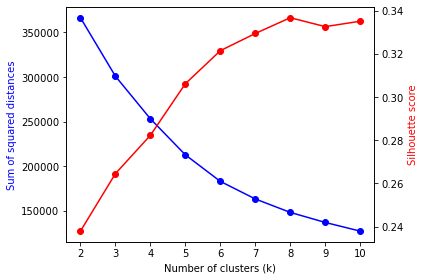

In [21]:
kmeans_elbow_method(transformed_scaled_data)

/home/FYP/teog0015/.conda/envs/fyp_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


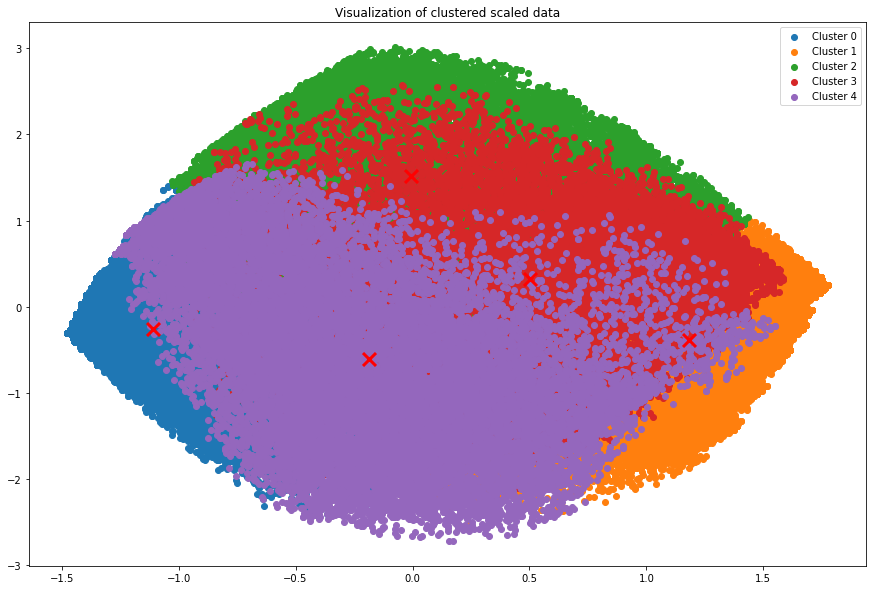

In [22]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(transformed_scaled_data)
cluster_labels = kmeans.labels_
kmeans_centroids = kmeans.cluster_centers_
#print(kmeans_centroids)
kmeans_silhouette = silhouette_score(transformed_scaled_data, cluster_labels)
plt.figure(figsize=(15,10))
for i in range(k):
    plt.scatter(transformed_scaled_data[cluster_labels == i, 0], transformed_scaled_data[cluster_labels == i, 1], label='Cluster '+str(i))
plt.legend()

# Plot the centroids
plt.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], marker='x', s=169, linewidths=3, color='r', zorder=10)
plt.title('Visualization of clustered scaled data')
plt.show()

In [23]:
Kmeans_silhouette, Kmeans_davies_bouldin, Kmeans_calinski_harabasz = evaluate_clustering(kmeans.labels_, transformed_scaled_data)

print(f'Kmeans Silhouette score: {Kmeans_silhouette}')
print(f'Kmeans Davies-Bouldin Index: {Kmeans_davies_bouldin}')
print(f'Kmeans Calinski-Harabasz Index: {Kmeans_calinski_harabasz}')

Kmeans Silhouette score: 0.30616943961869775
Kmeans Davies-Bouldin Index: 1.2170460646040901
Kmeans Calinski-Harabasz Index: 34402.46036684858


In [29]:
# Account for frequencies
def normalize_frequent_itemsets(binary_matrix, itemset_frequencies):
    # For each column in the binary matrix
    for column in binary_matrix.columns:
        # Find the level of the itemset (number of items in the itemset)
        if(column == 'anime_level' or column=='kmeans_cluster'):
            continue
        level = len(column)

        # Get the frequency of the itemset from the dictionary
        frequency = itemset_frequencies[level][column]

        # Normalize the column by the itemset frequency
        binary_matrix[column] = binary_matrix[column] / frequency

    return binary_matrix



In [30]:
normalized_matrix = normalize_frequent_itemsets(binary_matrix, frequent_itemsets)

In [34]:
normalized_matrix =normalized_matrix.drop(columns=['kmeans_cluster', 'anime_level'])
normalized_matrix

,"(Angel Beats!,)","(Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.,)","(Another,)","(Ao no Exorcist,)","(Bakemonogatari,)","(Bleach,)","(Byousoku 5 Centimeter,)","(Clannad,)","(Clannad: After Story,)","(Code Geass: Hangyaku no Lelouch,)",...,"(Naruto, Naruto: Shippuuden)","(Shingeki no Kyojin, Steins;Gate)","(Shingeki no Kyojin, Sword Art Online)","(Shingeki no Kyojin, Toradora!)","(Steins;Gate, Sword Art Online)","(Sword Art Online, Toradora!)","(Code Geass: Hangyaku no Lelouch, Code Geass: Hangyaku no Lelouch R2, Death Note)","(Code Geass: Hangyaku no Lelouch, Death Note, Elfen Lied)","(Code Geass: Hangyaku no Lelouch, Death Note, Fullmetal Alchemist: Brotherhood)","(Death Note, Shingeki no Kyojin, Sword Art Online)"
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.519048e-10,2.517688e-10,0.000000e+00,1.960800e-10,...,3.933325e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.829642e-10,4.602219e-10,0.000000e+00,0.000000e+00
1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,2.344951e-10,0.000000e+00,3.747355e-10,3.556227e-10,3.048598e-10,0.000000e+00,0.000000e+00,2.517688e-10,0.000000e+00,0.000000e+00,...,3.933325e-10,4.036082e-10,3.296070e-10,4.472908e-10,4.150350e-10,4.236735e-10,0.000000e+00,0.000000e+00,0.000000e+00,4.399286e-10
4,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.452046e-10,4.519048e-10,0.000000e+00,0.000000e+00,0.000000e+00,...,3.933325e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116119,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.452046e-10,4.519048e-10,2.517688e-10,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
116120,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.519048e-10,0.000000e+00,0.000000e+00,1.960800e-10,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.829642e-10,4.602219e-10,0.000000e+00,0.000000e+00
116121,2.344951e-10,4.088481e-10,3.747355e-10,3.556227e-10,3.048598e-10,2.452046e-10,0.000000e+00,2.517688e-10,3.983412e-10,1.960800e-10,...,3.933325e-10,4.036082e-10,3.296070e-10,4.472908e-10,4.150350e-10,4.236735e-10,3.829642e-10,0.000000e+00,4.404457e-10,4.399286e-10
116122,2.344951e-10,4.088481e-10,3.747355e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.517688e-10,3.983412e-10,1.960800e-10,...,0.000000e+00,4.036082e-10,3.296070e-10,0.000000e+00,4.150350e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


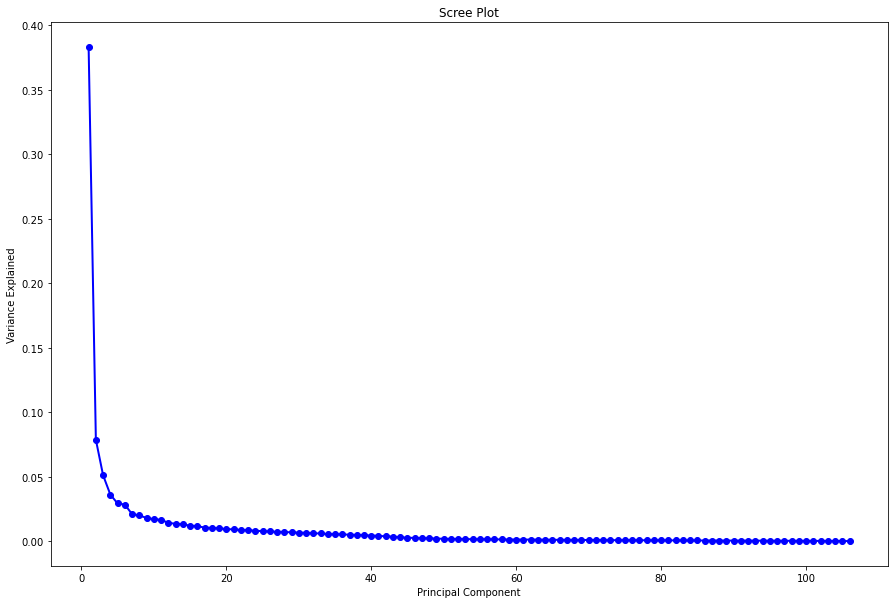

In [35]:
pca = PCA(random_state=24).fit(normalized_matrix)
PC_values = np.arange(pca.n_components_) + 1
plt.figure(figsize=(15,10))
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [36]:
pca = PCA(n_components=4, random_state=42)
transformed_normalized_data = pca.fit_transform(normalized_matrix)

/home/FYP/teog0015/.conda/envs/fyp_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/FYP/teog0015/.conda/envs/fyp_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/FYP/teog0015/.conda/envs/fyp_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/FYP/teog0015/.conda/envs/fyp_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly t

<Figure size 1080x576 with 0 Axes>

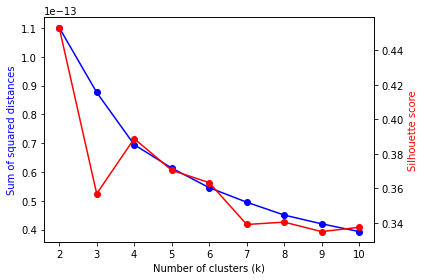

In [37]:
kmeans_elbow_method(transformed_normalized_data)

/home/FYP/teog0015/.conda/envs/fyp_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


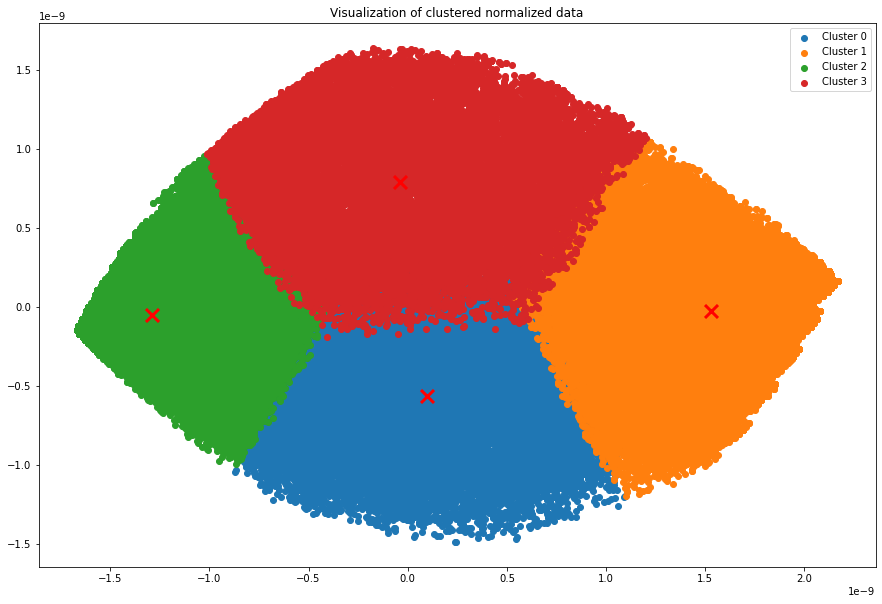

In [38]:
# Number of cluster for K-means to be 4 
k = 4
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(transformed_normalized_data)
cluster_labels = kmeans.labels_
kmeans_centroids = kmeans.cluster_centers_
#print(kmeans_centroids)
kmeans_silhouette = silhouette_score(transformed_normalized_data, cluster_labels)
plt.figure(figsize=(15,10))
for i in range(k):
    plt.scatter(transformed_normalized_data[cluster_labels == i, 0], transformed_normalized_data[cluster_labels == i, 1], label='Cluster '+str(i))
plt.legend()

# Plot the centroids

plt.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], marker='x', s=169, linewidths=3, color='r', zorder=10)
plt.title('Visualization of clustered normalized data')
plt.show()

In [39]:
Kmeans_silhouette, Kmeans_davies_bouldin, Kmeans_calinski_harabasz = evaluate_clustering(kmeans.labels_, transformed_normalized_data)

print(f'Kmeans Normalized Silhouette score: {Kmeans_silhouette}')
print(f'Kmeans Normalized Davies-Bouldin Index: {Kmeans_davies_bouldin}')
print(f'Kmeans Normalized Calinski-Harabasz Index: {Kmeans_calinski_harabasz}')

Kmeans Silhouette score: 0.38880943125578304
Kmeans Davies-Bouldin Index: 0.0
Kmeans Calinski-Harabasz Index: 93217.20296844139
